<br>

# Introdução

In [407]:
import os
import sys
import pandas as pd

In [408]:
import dash
from dash import Dash, dcc, html, Input, Output
from jupyter_dash import JupyterDash

In [409]:
import plotly.express as px
import plotly.graph_objects as go

In [410]:
mod_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(mod_path)

In [411]:
from sisagua.ibge import *

In [412]:
from paths import *

In [413]:
# Parameters
cod_ibge = '3548906' # São Carlos
cod_ibge = '3526902' # Limeira
cod_ibge = '3501608' # Americana

# Adjust Code
#cod_ibge_adjusted = adjust_id_ibge(cod_ibge)

<br>

# Lê Dados da Vigilância

In [414]:
# Read Table
df = pd.read_excel(
    os.path.join(output_path, str(cod_ibge), 'dados brutos', 'vigilancia', 'vigilancia_parametros_basicos.xlsx')
)

<br>

# Filtra

In [415]:
print(set(df['Tipo Da Forma De Abastecimento']))

df = df.loc[df['Tipo Da Forma De Abastecimento'] == 'SAA']
df.head()

{'SAC', 'SAA'}


,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
0,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2308/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_LABORATORIO,"0,80",NaN,SP,350160
1,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1952/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,"5,40",SOLICITADO A RECOLETA AO DEPARTAMENTO DE ÁGUA ...,SP,350160
2,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,10111507,Rotina,SAA,S350160000002,DEPARTAMENTO DE AGUA E ESGOTO,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,"1,5",NaN,SP,350160
3,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,0865/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,"0,60",NaN,SP,350160
4,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2991505,Rotina,SAA,S350160000002,DEPARTAMENTO DE AGUA E ESGOTO,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,"1,5",NaN,SP,350160


<br>

# Adjust Dates

In [416]:
df['Data Da Coleta'] = pd.to_datetime(df['Data Da Coleta'])
df['Data Do Laudo'] = pd.to_datetime(df['Data Do Laudo'])
df['Data De Registro No Sisagua'] = pd.to_datetime(df['Data De Registro No Sisagua'])

<br>

# Análises

In [417]:
# Results
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4133 entries, 0 to 6342
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Região Geográfica                  4133 non-null   object        
 1   Regional De Saúde                  4133 non-null   object        
 2   Município                          4133 non-null   object        
 3   Número Da Amostra                  4133 non-null   object        
 4   Motivo Da Coleta                   4133 non-null   object        
 5   Tipo Da Forma De Abastecimento     4133 non-null   object        
 6   Código Forma De Abastecimento      4133 non-null   object        
 7   Nome Da Forma De Abastecimento     4133 non-null   object        
 8   Tipo Da Instituição                4133 non-null   object        
 9   Sigla Da Instituição               0 non-null      float64       
 10  Nome Da Instituição                4

In [418]:
list_cols = ['Região Geográfica', 'Regional De Saúde', 'Município']
df[list_cols].drop_duplicates()

,Região Geográfica,Regional De Saúde,Município
0,SUDESTE,GVS XVII - CAMPINAS,AMERICANA


In [419]:
list_cols = [
    'Código Forma De Abastecimento',
    'Tipo Da Forma De Abastecimento',
    'Nome Da Forma De Abastecimento',
]
df[list_cols].drop_duplicates()

,Código Forma De Abastecimento,Tipo Da Forma De Abastecimento,Nome Da Forma De Abastecimento
0,S350160000001,SAA,ETA
2,S350160000002,SAA,DEPARTAMENTO DE AGUA E ESGOTO


In [420]:
list_cols = [
    'Tipo Da Instituição',
    'Sigla Da Instituição',
    'Nome Da Instituição',
    'Cnpj Da Instituição',
    'Nome Do Escritório Regional/Local',
    'Cnpj Do Escritório Regional/Local'
]
df[list_cols].drop_duplicates()

,Tipo Da Instituição,Sigla Da Instituição,Nome Da Instituição,Cnpj Da Instituição,Nome Do Escritório Regional/Local,Cnpj Do Escritório Regional/Local
0,Serviço Municipal e outros,NaN,DEPARTAMENTO DE AGUA E ESGOTO,4.675569e+13,NaN,NaN


In [421]:
list_cols = [
    'Procedência Da Coleta',
    'Ponto De Coleta',
    #'Área',
    #'Descrição Do Local',
    'Zona',
    'Categoria Área',    
]
df[list_cols].drop_duplicates()

,Procedência Da Coleta,Ponto De Coleta,Zona,Categoria Área
0,SISTEMA DE DISTRIBUIÇÃO,Cavalete/Hidrômetro,Urbana,Bairro
8,SISTEMA DE DISTRIBUIÇÃO,Reservatório de distribuição,Urbana,Bairro
1334,INTRA-DOMICILIAR / INTRA-PREDIAL,Torneira após a reservação,Urbana,Bairro
4876,INTRA-DOMICILIAR / INTRA-PREDIAL,Reservatório de água,Urbana,Bairro


In [422]:
list_cols = [    
    'Zona',
    'Categoria Área',
    'Tipo Do Local',
    'Área',
    'Descrição Do Local',
    'Local',
]
df[list_cols].drop_duplicates()

,Zona,Categoria Área,Tipo Do Local,Área,Descrição Do Local,Local
0,Urbana,Bairro,NaN,RESIDENCIAL BOA VISTA,"RUA HUDSON H CARVALHO, 867",NaN
1,Urbana,Bairro,NaN,PARQUE RESIDENCIAL JAGUARI,"RUA LAMARTINE BABO, 96",NaN
2,Urbana,Bairro,NaN,JARDIM IPIRANGA,NaN,NaN
3,Urbana,Bairro,NaN,ANTONIO ZANAGA,"RUA BENEDITO CALIXTO, 563",NaN
4,Urbana,Bairro,NaN,VILA DAINESE,RUA JAGUARÃO 210,NaN
...,...,...,...,...,...,...
5292,Urbana,Bairro,NaN,LOTEAMENTO INDUSTRIAL NOSSA SENHORA DE FATIMA,AV NOSSA SENHORA DE FATIMA 8297,NaN
5357,Urbana,Bairro,NaN,CIDADE JARDIM II,RUA DAS DALIAS 145,NaN
5436,Urbana,Bairro,NaN,VILA CORDENONSI,RUA PROF MIGUEL COUTO 07,NaN
6302,Urbana,Bairro,NaN,CIDADE JARDIM I,RUA DAS DALIAS 145,NaN


In [423]:
list_cols = [
    'Latitude',
    'Longitude'
]
df[list_cols].drop_duplicates()

,Latitude,Longitude
0,NaN,NaN


In [424]:
list(df.columns)

['Região Geográfica',
 'Regional De Saúde',
 'Município',
 'Número Da Amostra',
 'Motivo Da Coleta',
 'Tipo Da Forma De Abastecimento',
 'Código Forma De Abastecimento',
 'Nome Da Forma De Abastecimento',
 'Tipo Da Instituição',
 'Sigla Da Instituição',
 'Nome Da Instituição',
 'Cnpj Da Instituição',
 'Nome Do Escritório Regional/Local',
 'Cnpj Do Escritório Regional/Local',
 'Nome Da Eta/Uta',
 'Ano',
 'Mês',
 'Data Da Coleta',
 'Data Do Laudo',
 'Data De Registro No Sisagua',
 'Procedência Da Coleta',
 'Ponto De Coleta',
 'Descrição Do Local',
 'Zona',
 'Categoria Área',
 'Área',
 'Tipo Do Local',
 'Local',
 'Latitude',
 'Longitude',
 'Parâmetro (Parâmetros Básicos)',
 'Análise Realizada',
 'Resultado',
 'Providência',
 'Uf',
 'Código Ibge']

In [425]:
list_cols = [
    'Número Da Amostra',
    'Motivo Da Coleta',    
    'Parâmetro (Parâmetros Básicos)',
    'Análise Realizada',
    'Resultado',
    'Providência',
]
df[list_cols].drop_duplicates()

,Número Da Amostra,Motivo Da Coleta,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência
0,2308/15,Rotina,Turbidez (uT),EM_LABORATORIO,"0,80",NaN
1,1952/15,Rotina,Cloro residual livre (mg/L),EM_CAMPO,"5,40",SOLICITADO A RECOLETA AO DEPARTAMENTO DE ÁGUA ...
2,10111507,Rotina,Cloro residual livre (mg/L),EM_CAMPO,"1,5",NaN
3,0865/15,Rotina,Fluoreto (mg/L),NaN,"0,60",NaN
4,2991505,Rotina,Cloro residual livre (mg/L),EM_CAMPO,"1,5",NaN
...,...,...,...,...,...,...
6332,221741000005,Rotina,Coliformes totais,NaN,AUSENTE,NaN
6333,221741000007,Rotina,Escherichia coli,NaN,AUSENTE,NaN
6336,221741000006,Rotina,Coliformes totais,NaN,AUSENTE,NaN
6337,221741000006,Rotina,Escherichia coli,NaN,AUSENTE,NaN


In [426]:
set(df['Análise Realizada'])

{'EM_CAMPO', 'EM_LABORATORIO', nan}

In [427]:
set(df['Parâmetro (Parâmetros Básicos)'])

{'Cloro residual livre (mg/L)',
 'Coliformes totais',
 'Cor (uH)',
 'Escherichia coli',
 'Fluoreto (mg/L)',
 'Turbidez (uT)',
 'pH'}

<br>

## Seleciona Parâmetros

In [428]:
dict_par = {
    'Cloro residual livre (mg/L)': 2,
    'Coliformes totais': 2,
    'Cor (uH)': 2,
    'Escherichia coli': 2,
    'Fluoreto (mg/L)': 2,
    'Turbidez (uT)': 2,
    'pH': 2
}

In [429]:
set(df['Parâmetro (Parâmetros Básicos)'])

{'Cloro residual livre (mg/L)',
 'Coliformes totais',
 'Cor (uH)',
 'Escherichia coli',
 'Fluoreto (mg/L)',
 'Turbidez (uT)',
 'pH'}

In [430]:
#df.dtypes

In [431]:
#list(df.columns)

<br>

# Plotly

In [432]:
print(list(set(df['Nome Da Forma De Abastecimento'])))
n_forma = 1

['ETA', 'DEPARTAMENTO DE AGUA E ESGOTO']


<br>

## Cloro

- Art. 32 É obrigatória a manutenção de, no mínimo, 0,2 mg/L de cloro residual livre ou 2 mg/L de cloro residual combinado ou de 0,2 mg/L de dióxido de cloro em toda a extensão do sistema de distribuição (reservatório e rede) e nos pontos de consumo.

In [433]:
# Select Parameters
df_temp = df[df['Parâmetro (Parâmetros Básicos)'].str.contains('Cloro')].copy()
print(list(set(df_temp['Parâmetro (Parâmetros Básicos)'])))

# Ajusta Resultados
df_temp['Resultado'] = df_temp['Resultado'].astype(str).str.replace(',','.')
df_temp['Resultado'] = df_temp['Resultado'].astype(float).fillna(0.0)
df_temp.head()

['Cloro residual livre (mg/L)']


,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
1,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1952/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,5.4,SOLICITADO A RECOLETA AO DEPARTAMENTO DE ÁGUA ...,SP,350160
2,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,10111507,Rotina,SAA,S350160000002,DEPARTAMENTO DE AGUA E ESGOTO,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,1.5,NaN,SP,350160
4,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2991505,Rotina,SAA,S350160000002,DEPARTAMENTO DE AGUA E ESGOTO,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,1.5,NaN,SP,350160
7,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,13101508,Rotina,SAA,S350160000002,DEPARTAMENTO DE AGUA E ESGOTO,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,2.7,NaN,SP,350160
8,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1727/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Cloro residual livre (mg/L),EM_CAMPO,5.0,NaN,SP,350160


['ETA', 'DEPARTAMENTO DE AGUA E ESGOTO']
DEPARTAMENTO DE AGUA E ESGOTO


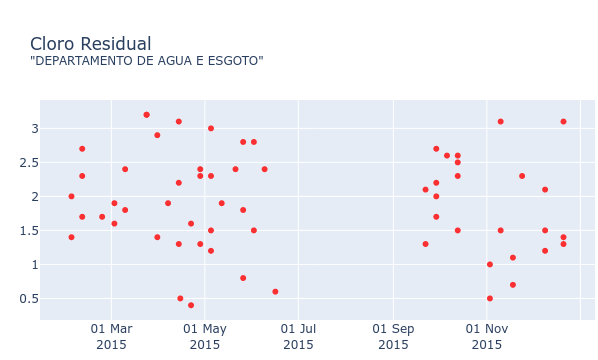

In [434]:
list_formas = list(set(df_temp['Nome Da Forma De Abastecimento']))
print(list_formas)
xaxis_column_name = list_formas[n_forma]
print(xaxis_column_name)

# Create Figure
fig = go.Figure()

# Add trace
fig.add_trace(
    go.Scatter(
        x=df_temp['Data Da Coleta'],
        #y=df['Resultado'],
        y=df_temp[df_temp['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
        name='conclusao',
        mode='markers',
        marker={'color': 'red'},
        opacity=0.8,
    )
)

# Udate
fig.update_layout(
    title='Cloro Residual<br><sup>"{}"</sup>'.format(xaxis_column_name),
    xaxis_tickformat='%d %b<br>%Y',
    margin={
        'l': 40,
        'b': 40,
        #'t': 40,
        'r': 0
    },
    #dragmode='pan',
    hovermode='x',

)
#fig.write_html('ddd.html', config=config)
fig

<br>

## Coliformes

In [435]:
# Select Parameters
df_temp = df[df['Parâmetro (Parâmetros Básicos)'].str.contains('Coliformes')].copy()

# Ajusta Resultados
df_temp['Resultado'] = df_temp['Resultado'].map({'AUSENTE': 0, 'PRESENTE': 1})

df_temp.head()

,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
473,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1330/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Coliformes totais,NaN,0,NaN,SP,350160
474,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2501/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Coliformes totais,NaN,0,NaN,SP,350160
476,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1325/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Coliformes totais,NaN,0,NaN,SP,350160
477,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,0810/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Coliformes totais,NaN,0,NaN,SP,350160
482,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1957/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Coliformes totais,NaN,0,NaN,SP,350160


In [436]:
list_formas = list(set(df_temp['Nome Da Forma De Abastecimento']))
print(list_formas)
xaxis_column_name = list_formas[n_forma]
print(xaxis_column_name)

# Create Figure
fig = go.Figure()

# Add trace
fig.add_trace(
    go.Scatter(
        x=df_temp['Data Da Coleta'],
        #y=df['Resultado'],
        y=df_temp[df_temp['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
        name='conclusao',
        mode='markers',
        marker={'color': 'red'},
        opacity=0.8,
    )
)

# Udate
fig.update_layout(
    title='Coliformes<br><sup>"{}"</sup>'.format(xaxis_column_name),
    xaxis_tickformat='%d %b<br>%Y',
    margin={
        'l': 40,
        'b': 40,
        #'t': 40,
        'r': 0
    },
    #dragmode='pan',
    hovermode='x',

)
#fig.write_html('ddd.html', config=config)
fig

['ETA']


IndexError: list index out of range

<br>

## Escherichia

In [437]:
# Select Parameters
df_temp = df[df['Parâmetro (Parâmetros Básicos)'].str.contains('Escherichia')].copy()

# Ajusta Resultados
print(set(df_temp['Resultado']))
df_temp['Resultado'] = df_temp['Resultado'].map({'AUSENTE': 0, 'PRESENTE': 1})

df_temp.head()

{'AUSENTE', 'PRESENTE'}


,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
475,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1330/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Escherichia coli,NaN,0,NaN,SP,350160
478,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2249/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Escherichia coli,NaN,0,NaN,SP,350160
481,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1407/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Escherichia coli,NaN,0,NaN,SP,350160
483,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2085/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Escherichia coli,NaN,0,NaN,SP,350160
487,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1955/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Escherichia coli,NaN,0,NaN,SP,350160


In [438]:
list_formas = list(set(df_temp['Nome Da Forma De Abastecimento']))
print(list_formas)
xaxis_column_name = list_formas[n_forma]
print(xaxis_column_name)

# Create Figure
fig = go.Figure()

# Add trace
fig.add_trace(
    go.Scatter(
        x=df_temp['Data Da Coleta'],
        #y=df['Resultado'],
        y=df_temp[df_temp['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
        name='conclusao',
        mode='markers',
        marker={'color': 'red'},
        opacity=0.8,
    )
)

# Udate
fig.update_layout(
    title='Escherichia<br><sup>"{}"</sup>'.format(xaxis_column_name),
    xaxis_tickformat='%d %b<br>%Y',
    margin={
        'l': 40,
        'b': 40,
        #'t': 40,
        'r': 0
    },
    #dragmode='pan',
    hovermode='x',

)
#fig.write_html('ddd.html', config=config)
fig

['ETA']


IndexError: list index out of range

<br>

## Fluoreto

In [439]:
# Select Parameters
df_temp = df[df['Parâmetro (Parâmetros Básicos)'].str.contains('Fluoreto')].copy()

# Ajusta Resultados
df_temp['Resultado'] = df_temp['Resultado'].astype(str).str.replace(',','.')
df_temp['Resultado'] = df_temp['Resultado'].astype(float).fillna(0.0)
df_temp.head()

,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
3,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,0865/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,0.6,NaN,SP,350160
20,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1326/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,0.6,NaN,SP,350160
22,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1330/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,0.6,NaN,SP,350160
24,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2496/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,0.7,NaN,SP,350160
26,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,1519/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Fluoreto (mg/L),NaN,0.7,NaN,SP,350160


In [440]:
list_formas = list(set(df_temp['Nome Da Forma De Abastecimento']))
print(list_formas)
xaxis_column_name = list_formas[n_forma]
print(xaxis_column_name)

# Create Figure
fig = go.Figure()

# Add trace
fig.add_trace(
    go.Scatter(
        x=df_temp['Data Da Coleta'],
        #y=df['Resultado'],
        y=df_temp[df_temp['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
        name='conclusao',
        mode='markers',
        marker={'color': 'red'},
        opacity=0.8,
    )
)

# Udate
fig.update_layout(
    title='Fluoereto<br><sup>"{}"</sup>'.format(xaxis_column_name),
    xaxis_tickformat='%d %b<br>%Y',
    margin={
        'l': 40,
        'b': 40,
        #'t': 40,
        'r': 0
    },
    #dragmode='pan',
    hovermode='x',

)
#fig.write_html('ddd.html', config=config)
fig

['ETA']


IndexError: list index out of range

<br>

## Turbidez

Art. 28 Para a garantia da qualidade microbiológica da água, em complementação às exigências relativas aos indicadores microbiológicos, deve ser atendido o padrão de turbidez expresso no Anexo 2 e devem ser observadas as demais exigências contidas neste Anexo.

§ 2º Em toda a extensão do sistema de distribuição (reservatório e rede) ou pontos de consumo deverá atender ao VMP de 5,0 uT para turbidez.

In [441]:
# Select Parameters
df_temp = df[df['Parâmetro (Parâmetros Básicos)'].str.contains('Turbidez')].copy()

# Ajusta Resultados
df_temp['Resultado'] = df_temp['Resultado'].astype(str).str.replace(',','.')
df_temp['Resultado'] = df_temp['Resultado'].astype(float).fillna(0.0)
df_temp.head()

,Região Geográfica,Regional De Saúde,Município,Número Da Amostra,Motivo Da Coleta,Tipo Da Forma De Abastecimento,Código Forma De Abastecimento,Nome Da Forma De Abastecimento,Tipo Da Instituição,Sigla Da Instituição,...,Tipo Do Local,Local,Latitude,Longitude,Parâmetro (Parâmetros Básicos),Análise Realizada,Resultado,Providência,Uf,Código Ibge
0,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2308/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_LABORATORIO,0.8,NaN,SP,350160
6,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2496/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_LABORATORIO,1.2,NaN,SP,350160
10,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,0812/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_CAMPO,1.2,NaN,SP,350160
16,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2500/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_CAMPO,0.8,NaN,SP,350160
17,SUDESTE,GVS XVII - CAMPINAS,AMERICANA,2312/15,Rotina,SAA,S350160000001,ETA,Serviço Municipal e outros,NaN,...,NaN,NaN,NaN,NaN,Turbidez (uT),EM_CAMPO,0.6,NaN,SP,350160


['ETA']
ETA


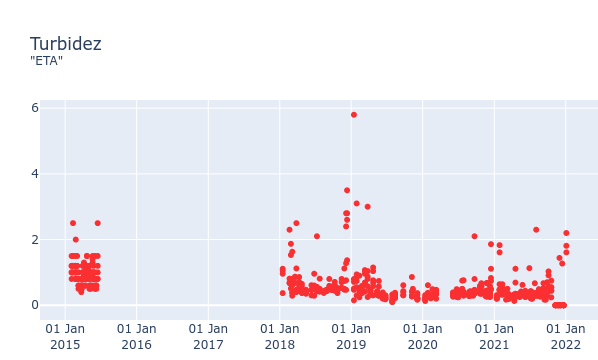

In [399]:
list_formas = list(set(df_temp['Nome Da Forma De Abastecimento']))
print(list_formas)
xaxis_column_name = list_formas[n_forma]
print(xaxis_column_name)

# Create Figure
fig = go.Figure()

# Add trace
fig.add_trace(
    go.Scatter(
        x=df_temp['Data Da Coleta'],
        #y=df['Resultado'],
        y=df_temp[df_temp['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
        name='conclusao',
        mode='markers',
        marker={'color': 'red'},
        opacity=0.8,
    )
)

# Udate
fig.update_layout(
    title='Turbidez<br><sup>"{}"</sup>'.format(xaxis_column_name),
    xaxis_tickformat='%d %b<br>%Y',
    margin={
        'l': 40,
        'b': 40,
        #'t': 40,
        'r': 0
    },
    #dragmode='pan',
    hovermode='x',

)
#fig.write_html('ddd.html', config=config)
fig

<br>

# Dash

In [393]:
# Start
app = JupyterDash(__name__)

# 
app.layout = html.Div([
    html.Div([
        html.Div(
            [
                dcc.Dropdown(
                    df['Nome Da Forma De Abastecimento'].unique(),
                    #value='Fertility rate, total (births per woman)',
                    id='xaxis-column'
                ),
            ],
            style={'width': '48%', 'display': 'inline-block'}),
    ]),

    dcc.Graph(id='indicator-graphic'),
])

@app.callback(
    Output('indicator-graphic', 'figure'),
    Input('xaxis-column', 'value'),
)
def update_graph(xaxis_column_name):
    # Create Figure
    fig = go.Figure()
    
    # Add trace
    fig.add_trace(
        go.Scatter(
            x=df['Data Da Coleta'],
            #y=df['Resultado'],
            y=df[df['Nome Da Forma De Abastecimento'] == xaxis_column_name]['Resultado'],
            name='conclusao',
            mode='markers',
            marker={'color': 'red'},
            opacity=0.8,
        )
    )
    
    # Udate
    fig.update_layout(
        title='Cloro Residual na "{}"'.format(xaxis_column_name),
        xaxis_tickformat='%d %b<br>%Y',
        margin={
            'l': 40,
            'b': 40,
            #'t': 40,
            'r': 0
        },
        #dragmode='pan',
        hovermode='x',

    )
    #fig.write_html('ddd.html', config=config)
    return fig

# Run
app.run_server(mode='inline', port=8051)

<br>

# Export

In [28]:
import os
from traitlets.config import Config
from nbconvert import PythonExporter
from nbconvert.preprocessors import TagRemovePreprocessor

In [29]:
input_filename = '12_analysis_basics.ipynb'
input_filepath = os.path.join(os.getcwd(), input_filename)
output_filepath = os.path.abspath(os.path.join(os.getcwd(), '..', 'src', 'sisagua', 'dash_sisagua_lixo.py'))

print(output_filepath)

/home/michel/Codes/open_geodata/br_sisagua/src/sisagua/dash_sisagua.py


In [30]:
# Import the exporter
c = Config()
c.TagRemovePreprocessor.enabled=True
c.ClearOutputPreprocessor.enabled=True
c.TemplateExporter.exclude_markdown=True
c.TemplateExporter.exclude_code_cell=False
c.TemplateExporter.exclude_input_prompt=True 
c.TemplateExporter.exclude_output=True
c.TemplateExporter.exclude_raw=True
c.TagRemovePreprocessor.remove_cell_tags = ('remove_cell',)
c.TagRemovePreprocessor.remove_input_tags = ('remove_cell',)
c.TagRemovePreprocessor.remove_all_outputs_tags = ('remove_output',)
c.preprocessors = ['TagRemovePreprocessor']
c.PythonExporter.preprocessors = ['nbconvert.preprocessors.TagRemovePreprocessor']

# Configure and run out exporter
py_exporter = PythonExporter(config=c)
py_exporter.register_preprocessor(TagRemovePreprocessor(config=c), True)

# Configure and run out exporter - returns a tuple - first element with html, second with notebook metadata
body, metadata = PythonExporter(config=c).from_filename(input_filepath)

# Write to output html file
with open(output_filepath,  'w', encoding='utf-8') as f:
    f.write(body)